<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Select-model-from-testing-results" data-toc-modified-id="Select-model-from-testing-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Select model from testing results</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Set-train-and-test-sets-for-later-evaluation" data-toc-modified-id="Set-train-and-test-sets-for-later-evaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Set train and test sets for later evaluation</a></span></li><li><span><a href="#Define-evaluation-function" data-toc-modified-id="Define-evaluation-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Define evaluation function</a></span></li></ul></li><li><span><a href="#Base-model" data-toc-modified-id="Base-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Base model</a></span></li><li><span><a href="#1st-iteration" data-toc-modified-id="1st-iteration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>1st iteration</a></span></li><li><span><a href="#2nd-iteration-with-feature-reduction-KBest" data-toc-modified-id="2nd-iteration-with-feature-reduction-KBest-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>2nd iteration with feature reduction KBest</a></span></li><li><span><a href="#Last-iteration---fine-tune" data-toc-modified-id="Last-iteration---fine-tune-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Last iteration - fine tune</a></span></li><li><span><a href="#Final-model" data-toc-modified-id="Final-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final model</a></span></li></ul></div>

In [1]:
from category_encoders import TargetEncoder
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import base
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
sklearn.set_config(display='diagram')

# Select model from testing results

In [2]:
df_main = pd.read_csv('data_files/results_main.csv')
df_sf = pd.read_csv('data_files/results_sf.csv')
df_cookieless = pd.read_csv('data_files/results_cookieless.csv')

In [3]:
# annotate data source on each results df

df_main['model'] = df_main['model'].astype(str) + ' Main'
df_sf['model'] = df_sf['model'].astype(str) + ' SF'
df_cookieless['model'] = df_cookieless['model'].astype(str) + ' CL'

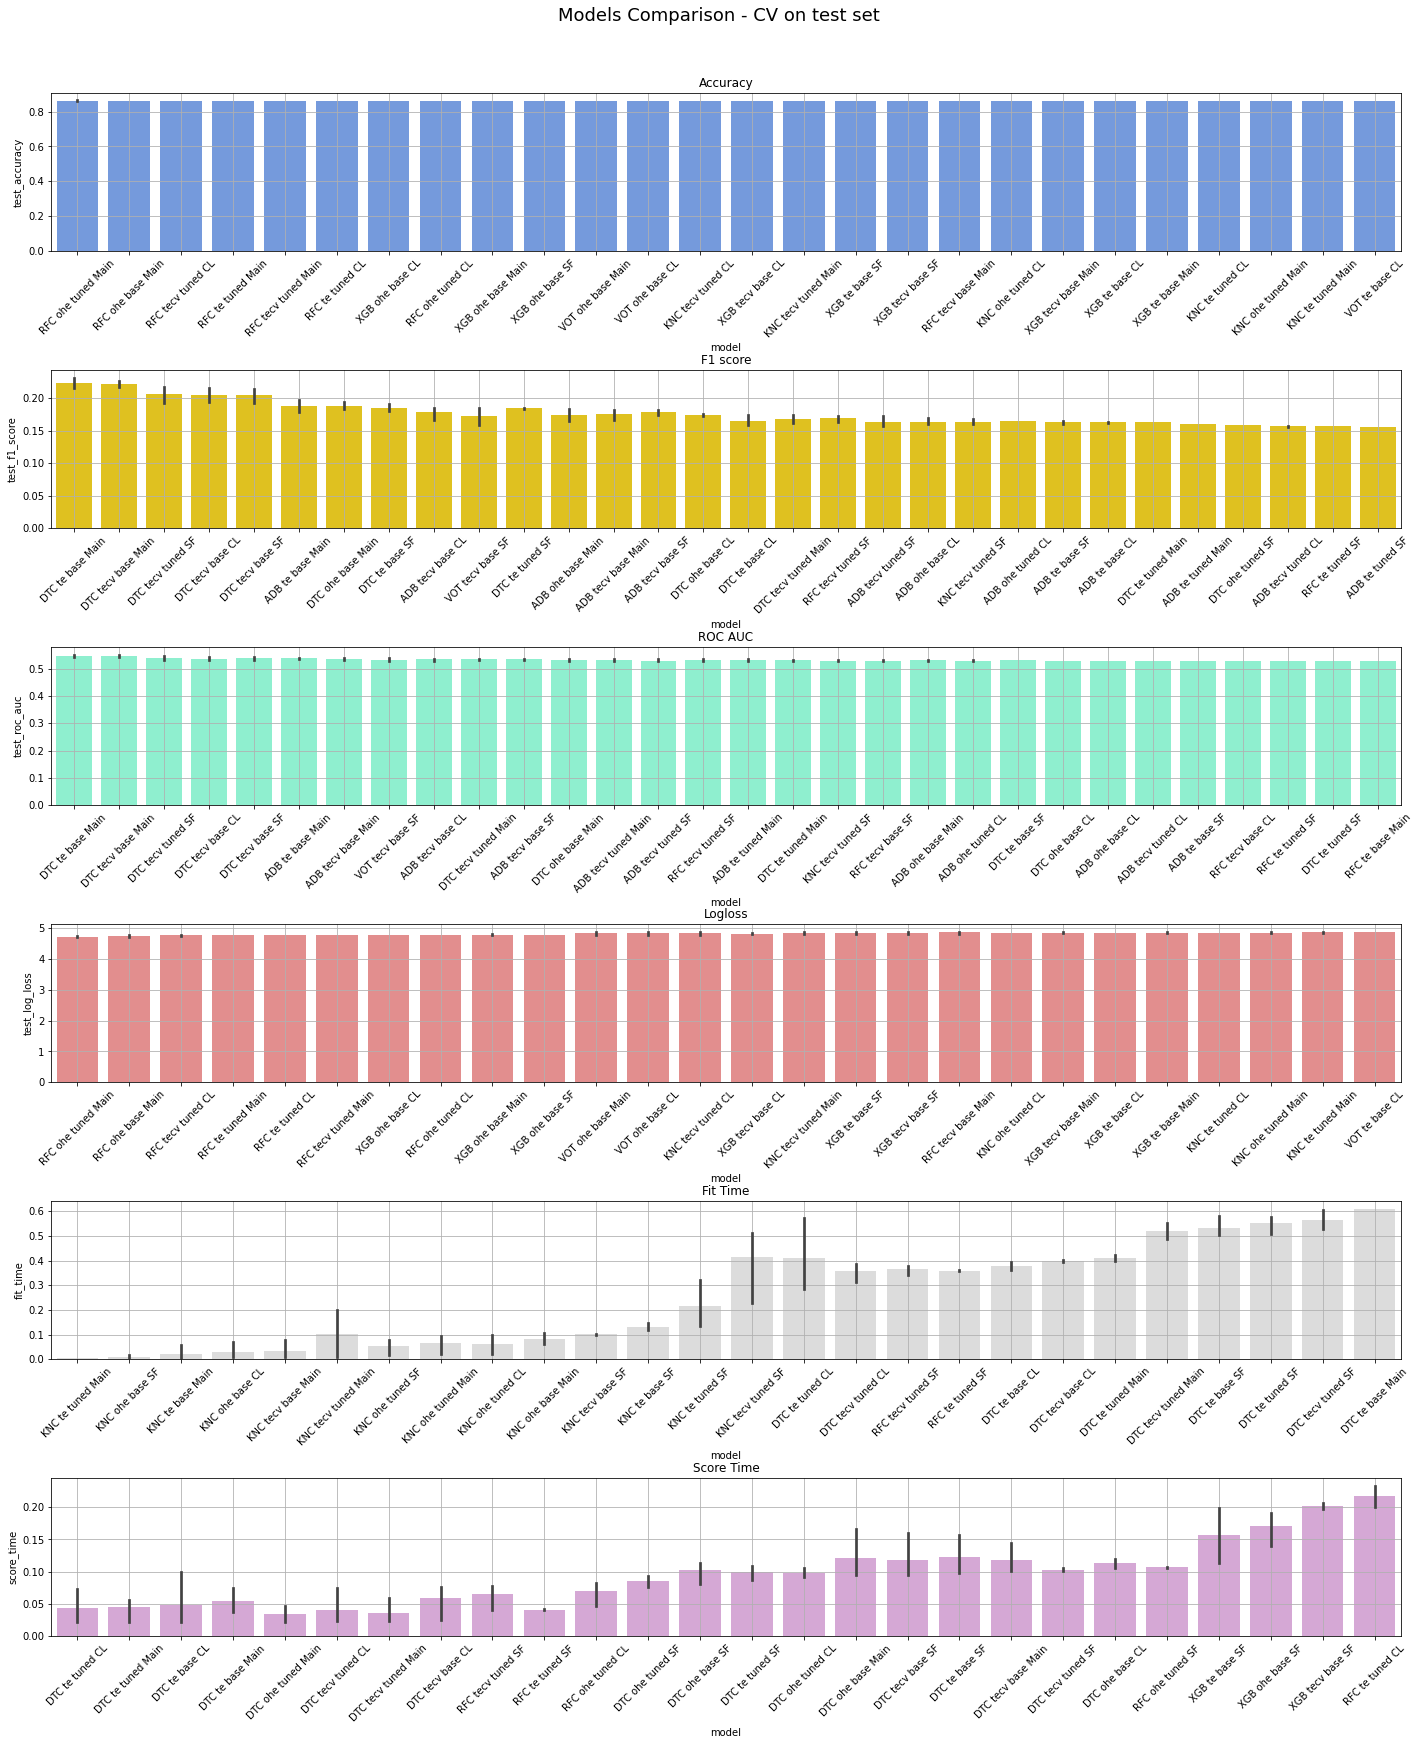

In [4]:
# concatenate dfs
results_all = pd.concat([df_main, df_sf, df_cookieless]).reset_index(drop=True)

# plot top scored
fig, ax = plt.subplots(6, figsize=(20,24))
fig.tight_layout(pad=3, rect=[0, 0.01, 1, 0.95])
fig.subplots_adjust(hspace=.75)
fig.suptitle('Models Comparison - CV on test set', size=18)

sns.barplot(x='model', y='test_accuracy', color='cornflowerblue', ax=ax[0], data=results_all.\
            sort_values('test_accuracy', ascending=False).head(75)).set_title('Accuracy')
ax[0].tick_params(axis='x', rotation=45)
ax[0].yaxis.grid(True)
ax[0].xaxis.grid(True)

sns.barplot(x='model', y='test_f1_score', color='gold', ax=ax[1], data=results_all.\
           sort_values('test_f1_score', ascending=False).head(75)).set_title('F1 score')
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.grid(True)
ax[1].xaxis.grid(True)

sns.barplot(x='model', y='test_roc_auc', color='aquamarine', ax=ax[2], data=results_all.\
           sort_values('test_roc_auc', ascending=False).head(75)).set_title('ROC AUC')
ax[2].tick_params(axis='x', rotation=45)
ax[2].yaxis.grid(True)
ax[2].xaxis.grid(True)

sns.barplot(x='model', y='test_log_loss', color='lightcoral', ax=ax[3], data=results_all.\
           sort_values('test_log_loss').head(75)).set_title('Logloss')
ax[3].tick_params(axis='x', rotation=45)
ax[3].yaxis.grid(True)
ax[3].xaxis.grid(True)

sns.barplot(x='model', y='fit_time', color='gainsboro', ax=ax[4], data=results_all.\
           sort_values('fit_time').head(75)).set_title('Fit Time')
ax[4].tick_params(axis='x', rotation=45)
ax[4].yaxis.grid(True)
ax[4].xaxis.grid(True)

sns.barplot(x='model', y='score_time', color='plum', ax=ax[5], data=results_all.\
           sort_values('score_time').head(75)).set_title('Score Time')
ax[5].tick_params(axis='x', rotation=45)
ax[5].yaxis.grid(True)
ax[5].xaxis.grid(True)

Let's use a DecisionTreeClassifier over the whole dataset (Main), with target encoding for preproc

# Data preparation

## Set train and test sets for later evaluation

In [5]:
# open csv and create X and y
csv_clean = 'data_files/preproc_clean.csv'
df_clean = pd.read_csv(csv_clean)
X = df_clean.loc[:, df_clean.columns != 'is_booking']
y = df_clean['is_booking']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
X_train.describe()

,new_cid,weekday,source,clean_medium,camp,device_category,device_browser,device_browser_version,device_operating_system,device_operating_system_version,device_mobile_branding,device_mobile_model,step0,step1,step2,step3,step4,step5,step6,step7,step8,step9,step10,steps_all
count,58883,58883,58883,58883,58726,58883,58883,58142,58883,58760,45127,45127,52053,52041,52026,52026,52047,52060,52051,52070,52058,46951,46934,45655
unique,2,7,244,8,275,2,27,465,10,126,26,1107,2,6,5,7,10,10,5,2,6,2,2,1002
top,new,Wednesday,facebook,facebook,facebook_fb_calculator,mobile,Chrome Mobile,92.0.4515,Android,10,Samsung,iPhone,home,chalet,primary,insideUrban,streetLevel,garden,yes,yes,always,no,no,home-chalet-primary-insideUrban-streetLevel-ga...
freq,54383,10195,26421,26872,6822,44436,15434,6313,39963,22128,22006,1973,47571,38517,43053,40587,39933,23458,33172,34633,17040,28698,28760,2910


## Define evaluation function

In [7]:
def eval_report(gs_be):

    ypred_train = gs_be.predict(X_train)
    ypred_test = gs_be.predict(X_test)  

    print(f'Train Accuracy: {round(accuracy_score(y_train, ypred_train)*100,3)} %')
    print((f'Test Accuracy: {round(accuracy_score(y_test, ypred_test)*100,3)} %'))
    print(f'Train F1: {round(f1_score(y_train, ypred_train)*100,3)} %')
    print((f'Test F1: {round(f1_score(y_test, ypred_test)*100,3)} % \n'))
    print('Classification report on test set')
    print(classification_report(y_test, ypred_test), '\n')

In [8]:
def evaluate(model):
    seed = 42
    results = []
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score),
               'roc_auc': make_scorer(roc_auc_score),
               'log_loss': make_scorer(log_loss)}

    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    cv_r = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_r)

    fig, ax = plt.subplots(2, 2, figsize=(10,8))
    fig.tight_layout(pad=4, rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Model metrics on cross validation', size=18)

    acc = [results[i]['test_accuracy'] for i, r in enumerate(results)]
    f1 = [results[i]['test_f1_score'] for i, r in enumerate(results)]
    roc_auc = [results[i]['test_roc_auc'] for i, r in enumerate(results)]
    logloss = [results[i]['test_log_loss'] for i, r in enumerate(results)]

    sns.boxplot(data=acc, color='cornflowerblue', ax=ax[0,0]).set(title='acc')
    sns.boxplot(data=f1, color='cornflowerblue', ax=ax[0,1]).set(title='f1')
    sns.boxplot(data=roc_auc, color='cornflowerblue', ax=ax[1,0]).set(title='roc_auc')
    sns.boxplot(data=logloss, color='cornflowerblue', ax=ax[1,1]).set(title='logloss');
    
    df = pd.DataFrame(results).apply(pd.Series.explode)

    return df

# Base model

In [9]:
# columns by type
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'bool']).columns

In [10]:
pipe_te = Pipeline(steps=[
    ('encoder', TargetEncoder(handle_unknown='return_nan')),
    ('imputer', SimpleImputer(strategy='mean'))])

preproc = ColumnTransformer(
    [('cat_preproc', pipe_te, cat_cols),
     ('num_preproc', SimpleImputer(strategy='constant', fill_value=0), num_cols)], remainder='passthrough')

pipe_base = Pipeline(steps=[('preproc', preproc),
                            ('reducer', SelectKBest(score_func=chi2)),
                            ('clf', DecisionTreeClassifier())])

In [11]:
%%time

pipe_base.fit(X_train, y_train)

CPU times: user 951 ms, sys: 176 ms, total: 1.13 s
Wall time: 997 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preproc',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(handle_unknown='return_nan')),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['new_cid', 'weekday', 'source', 'clean_medium', 'camp',
       'device_category', 'device_browser', 'device_browser_version',
       'device_operating_system', 'device...
       'device_mobile_branding', 'device_mobile_model', 'step0', 'step1',
       'step2', 'step3', 'step4', 'step5', 'step6', 'step7', 'step8', 'step9',
       'step10', 'steps_all'],
      dtype='object')),
                                                 ('num_preproc',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  Index([], dtype='object'))])),
                ('reducer',
                 SelectKBest(score_func=<function chi2 at 0x7fe1922fb048>)),
                ('clf', DecisionTreeClassifier())])

In [12]:
eval_report(pipe_base)

Train Accuracy: 98.643 %
Test Accuracy: 77.211 %
Train F1: 94.884 %
Test F1: 20.565 % 

Classification report on test set
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     16905
           1       0.20      0.21      0.21      2723

    accuracy                           0.77     19628
   macro avg       0.54      0.54      0.54     19628
weighted avg       0.78      0.77      0.78     19628
 



,fit_time,score_time,test_accuracy,test_f1_score,test_roc_auc,test_log_loss
0,0.773282,0.0942895,0.769309,0.203378,0.535664,7.96788
0,0.737768,0.0947905,0.767577,0.206056,0.536802,8.02771
0,0.75188,0.0974278,0.76298,0.192922,0.528602,8.1865


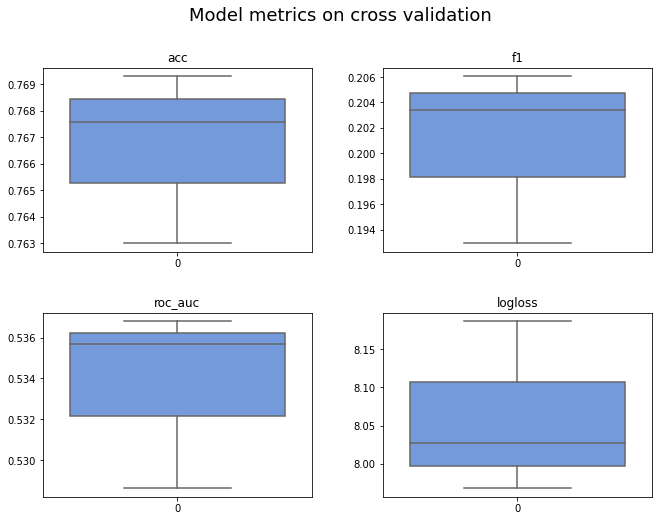

In [14]:
base = evaluate(pipe_base)
results = base.copy()
results.loc[:, 'model'] = 'base'

base

# 1st iteration

In [18]:
pipe_te = Pipeline(steps=[
    ('encoder', TargetEncoder(handle_unknown='return_nan')),
    ('imputer', SimpleImputer(strategy='mean'))])

preproc = ColumnTransformer(
    [('cat_preproc', pipe_te, cat_cols),
     ('num_preproc', SimpleImputer(strategy='constant', fill_value=0), num_cols)], remainder='passthrough')

pipeline_simple = Pipeline(steps=[('preproc', preproc),
                                  ('clf', DecisionTreeClassifier())])
params = {
    'preproc__cat_preproc__encoder__drop_invariant': [False, True],
    'preproc__cat_preproc__encoder__min_samples_leaf': [1, 5, 10],
    'preproc__cat_preproc__encoder__smoothing': [0.01, 0.1, 1],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__max_depth': [50, 100, 200],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
}

gs_simple = GridSearchCV(estimator = pipeline_simple,
                         param_grid = params,
                         scoring='f1',
                         cv=3,
                         n_jobs=-1,
                         verbose=10)

In [19]:
%%time

gs_simple.fit(X_train, y_train)
gs_simple.best_params_

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


/home/jupyter-igor.lopez/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.20290629 0.20292406        nan ... 0.07453899 0.07978238        nan]
  category=UserWarning
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: Runtime

CPU times: user 11min 5s, sys: 18.3 s, total: 11min 23s
Wall time: 1h 17min 57s


{'clf__criterion': 'entropy',
 'clf__max_depth': 200,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'preproc__cat_preproc__encoder__drop_invariant': False,
 'preproc__cat_preproc__encoder__min_samples_leaf': 10,
 'preproc__cat_preproc__encoder__smoothing': 0.01}

In [20]:
pipe_simple = gs_simple.best_estimator_
pipe_simple

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preproc',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(handle_unknown='return_nan',
                                                                                 min_samples_leaf=10,
                                                                                 smoothing=0.01)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['new_cid', 'weekday', 'source', 'clean_medium', 'camp',
       'device_category', 'device_browser', 'device_browser_version',
       'device_operating_system', 'device_operating_system_version',
       'device_mobile_branding', 'device_mobile_model', 'step0', 'step1',
       'step2', 'step3', 'step4', 'step5', 'step6', 'step7', 'step8', 'step9',
       'step10', 'steps_all'],
      dtype='object')),
                                                 ('num_preproc',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  Index([], dtype='object'))])),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=200,
                                        max_features='auto'))])

In [21]:
eval_report(pipe_simple)

Train Accuracy: 99.609 %
Test Accuracy: 77.726 %
Train F1: 98.572 %
Test F1: 20.625 % 

Classification report on test set
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16905
           1       0.20      0.21      0.21      2723

    accuracy                           0.78     19628
   macro avg       0.54      0.54      0.54     19628
weighted avg       0.78      0.78      0.78     19628
 



/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs

,fit_time,score_time,test_accuracy,test_f1_score,test_roc_auc,test_log_loss
0,0.621692,0.0956991,0.773691,0.201653,0.535588,7.81654
0,0.618112,0.097708,0.77043,0.202478,0.535377,7.92916
0,0.618197,0.0973332,0.771437,0.190253,0.529043,7.89437


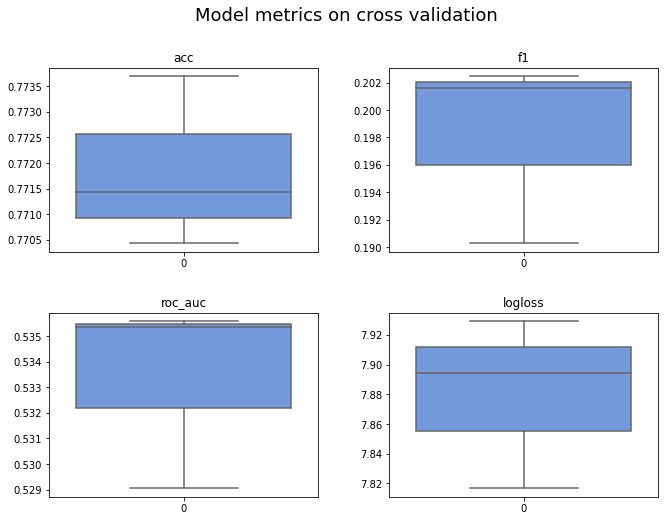

In [22]:
simple = evaluate(pipe_simple)
results = pd.concat([results, simple], ignore_index=True)
results.loc[results['model'].isnull(),'model'] = 'simple'

simple

# 2nd iteration with feature reduction KBest

In [23]:
gs_simple.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 200,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'preproc__cat_preproc__encoder__drop_invariant': False,
 'preproc__cat_preproc__encoder__min_samples_leaf': 10,
 'preproc__cat_preproc__encoder__smoothing': 0.01}

In [24]:
# let's explore feature reduction
# take hyperparms from first GS

pipe_te = Pipeline(steps=[
    ('encoder', TargetEncoder(handle_unknown='return_nan', drop_invariant='False', min_samples_leaf=10, smoothing=0.01)),
    ('imputer', SimpleImputer(strategy='mean'))])

preproc = ColumnTransformer(
    [('cat_preproc', pipe_te, cat_cols),
     ('num_preproc', SimpleImputer(strategy='constant', fill_value=0), num_cols)], remainder='passthrough')

pipe_reduce = Pipeline(steps=[('preproc', preproc),
                              ('reducer', SelectKBest(score_func=chi2)),
                              ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=200, max_features='auto'))])

params = {'reducer__k': range(5, len(X_train.columns))}

gs_reduce = GridSearchCV(estimator = pipe_reduce,
                         param_grid = params,
                         scoring='f1',
                         cv=10,
                         n_jobs=-1,
                         verbose=10)

In [25]:
%%time

gs_reduce.fit(X_train, y_train)
gs_reduce.best_params_

Fitting 10 folds for each of 19 candidates, totalling 190 fits


/home/jupyter-igor.lopez/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.15673726 0.187288   0.19169112 0.19280033 0.19831754 0.19546969
 0.19936607 0.19502245 0.19787322 0.19736299 0.20040082 0.2023999
 0.19943056 0.20141558 0.20630908        nan        nan        nan
        nan]
  category=UserWarning
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encounte

CPU times: user 15.5 s, sys: 516 ms, total: 16 s
Wall time: 3min


{'reducer__k': 19}

In [26]:
pipe_reduce = gs_reduce.best_estimator_
pipe_reduce

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preproc',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(drop_invariant='False',
                                                                                 handle_unknown='return_nan',
                                                                                 min_samples_leaf=10,
                                                                                 smoothing=0.01)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['new_cid', 'weekday', 'source', 'clean_medium', 'camp',
       'device_category', 'device_browser',...
       'step2', 'step3', 'step4', 'step5', 'step6', 'step7', 'step8', 'step9',
       'step10', 'steps_all'],
      dtype='object')),
                                                 ('num_preproc',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  Index([], dtype='object'))])),
                ('reducer',
                 SelectKBest(k=19,
                             score_func=<function chi2 at 0x7fe1922fb048>)),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=200,
                                        max_features='auto'))])

In [27]:
eval_report(pipe_reduce)

Train Accuracy: 99.091 %
Test Accuracy: 78.047 %
Train F1: 96.623 %
Test F1: 22.094 % 

Classification report on test set
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16905
           1       0.22      0.22      0.22      2723

    accuracy                           0.78     19628
   macro avg       0.55      0.55      0.55     19628
weighted avg       0.78      0.78      0.78     19628
 



/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs

,fit_time,score_time,test_accuracy,test_f1_score,test_roc_auc,test_log_loss
0,0.793796,0.0977163,0.774302,0.201514,0.535635,7.79542
0,0.793732,0.0979691,0.773079,0.190476,0.529521,7.83766
0,0.796827,0.0990095,0.772966,0.187751,0.528081,7.84157


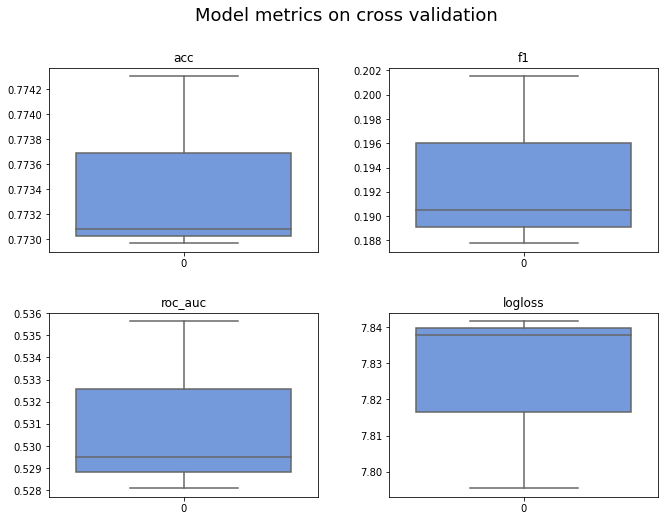

In [28]:
reduced = evaluate(pipe_reduce)
results = pd.concat([results, reduced], ignore_index=True)
results.loc[results['model'].isnull(),'model'] = 'reduced'

reduced

# Last iteration - fine tune

In [29]:
pipe_te = Pipeline(steps=[
    ('encoder', TargetEncoder(handle_unknown='return_nan')),
    ('imputer', SimpleImputer(strategy='mean'))])

preproc = ColumnTransformer(
    [('cat_preproc', pipe_te, cat_cols),
     ('num_preproc', SimpleImputer(strategy='constant', fill_value=0), num_cols)], remainder='passthrough')

pipe_last = Pipeline(steps=[('preproc', preproc),
                            ('reducer', SelectKBest(score_func=chi2)),
                            ('clf', DecisionTreeClassifier())])

params = {
    'preproc__cat_preproc__encoder__drop_invariant': [False, True],
    'preproc__cat_preproc__encoder__min_samples_leaf': [10, 15, 20],
    'preproc__cat_preproc__encoder__smoothing': [0.08, 0.1, 0.12],
    'reducer__k': range(5, 18),
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [30, 40, 50]
}

gs_last = GridSearchCV(estimator = pipe_last,
                       param_grid = params,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1,
                       verbose=10)

In [32]:
%%time

gs_last.fit(X_train, y_train)
gs_last.best_params_

Fitting 5 folds for each of 1404 candidates, totalling 7020 fits
CPU times: user 8min 58s, sys: 13.8 s, total: 9min 11s
Wall time: 1h 47min 23s


{'clf__criterion': 'entropy',
 'clf__max_depth': 50,
 'preproc__cat_preproc__encoder__drop_invariant': True,
 'preproc__cat_preproc__encoder__min_samples_leaf': 15,
 'preproc__cat_preproc__encoder__smoothing': 0.08,
 'reducer__k': 14}

In [33]:
pipe_last = gs_last.best_estimator_
pipe_last

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preproc',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(drop_invariant=True,
                                                                                 handle_unknown='return_nan',
                                                                                 min_samples_leaf=15,
                                                                                 smoothing=0.08)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['new_cid', 'weekday', 'source', 'clean_medium', 'camp',
       'device_category', 'device_browser', 'de...
       'device_mobile_branding', 'device_mobile_model', 'step0', 'step1',
       'step2', 'step3', 'step4', 'step5', 'step6', 'step7', 'step8', 'step9',
       'step10', 'steps_all'],
      dtype='object')),
                                                 ('num_preproc',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  Index([], dtype='object'))])),
                ('reducer',
                 SelectKBest(k=14,
                             score_func=<function chi2 at 0x7fe1922fb048>)),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=50))])

In [34]:
eval_report(pipe_last)

Train Accuracy: 98.976 %
Test Accuracy: 77.517 %
Train F1: 96.176 %
Test F1: 21.267 % 

Classification report on test set
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     16905
           1       0.21      0.22      0.21      2723

    accuracy                           0.78     19628
   macro avg       0.54      0.54      0.54     19628
weighted avg       0.78      0.78      0.78     19628
 



,fit_time,score_time,test_accuracy,test_f1_score,test_roc_auc,test_log_loss
0,0.9246,0.0967877,0.770379,0.196756,0.532279,7.93092
0,0.925168,0.097898,0.767424,0.198138,0.5324,8.03299
0,0.897034,0.098268,0.767107,0.19226,0.529149,8.04395


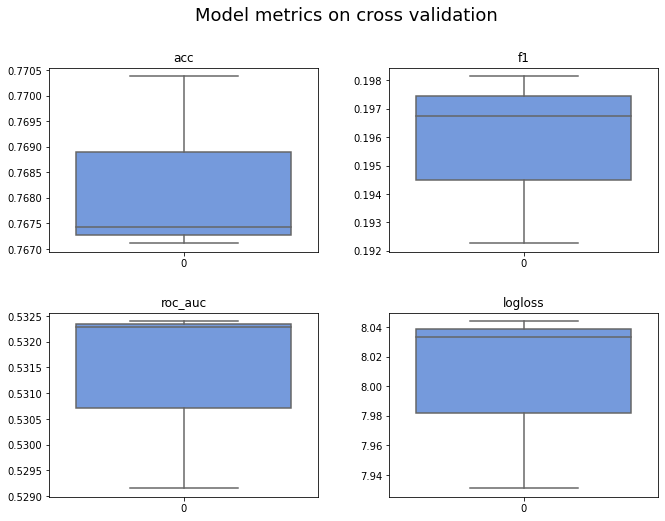

In [35]:
last = evaluate(pipe_last)
results = pd.concat([results, last], ignore_index=True)
results.loc[results['model'].isnull(),'model'] = 'last'

last

# Final model

In [36]:
results

,fit_time,score_time,test_accuracy,test_f1_score,test_roc_auc,test_log_loss,model
0,0.773282,0.0942895,0.769309,0.203378,0.535664,7.96788,base
1,0.737768,0.0947905,0.767577,0.206056,0.536802,8.02771,base
2,0.75188,0.0974278,0.76298,0.192922,0.528602,8.1865,base
3,0.621692,0.0956991,0.773691,0.201653,0.535588,7.81654,simple
4,0.618112,0.097708,0.77043,0.202478,0.535377,7.92916,simple
5,0.618197,0.0973332,0.771437,0.190253,0.529043,7.89437,simple
6,0.793796,0.0977163,0.774302,0.201514,0.535635,7.79542,reduced
7,0.793732,0.0979691,0.773079,0.190476,0.529521,7.83766,reduced
8,0.796827,0.0990095,0.772966,0.187751,0.528081,7.84157,reduced
9,0.9246,0.0967877,0.770379,0.196756,0.532279,7.93092,last


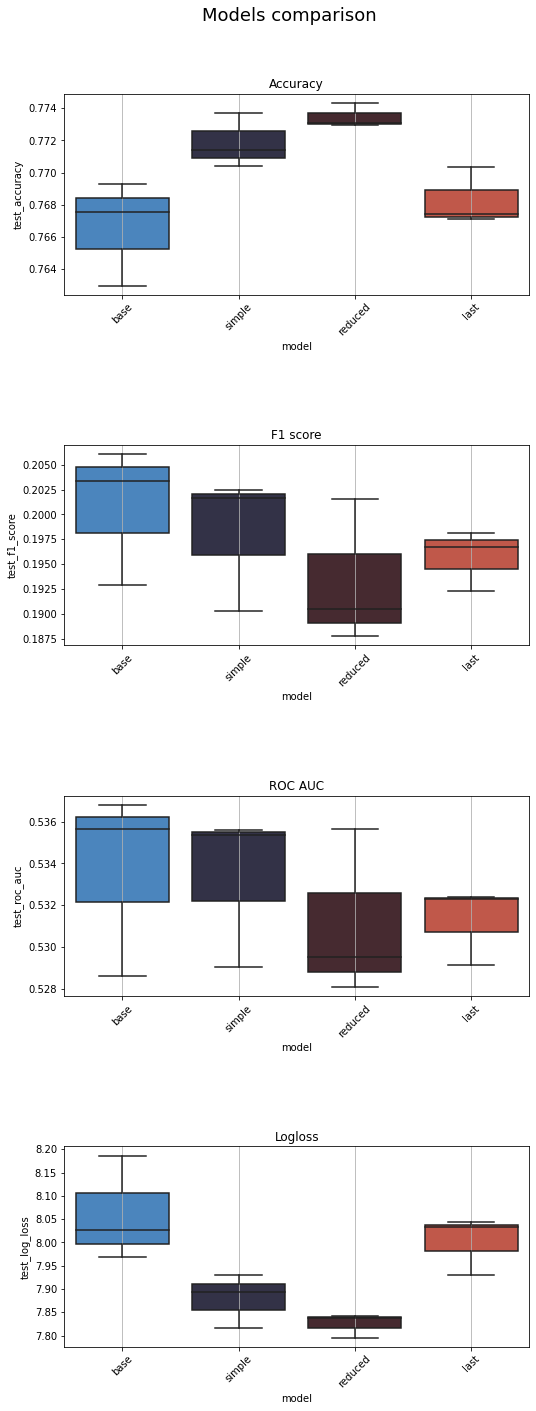

In [37]:
fig, ax = plt.subplots(4, figsize=(8,20))
fig.tight_layout(pad=4, rect=[0, 0.01, 1, 0.95])
fig.subplots_adjust(hspace=.75)
fig.suptitle('Models comparison', size=18)

sns.boxplot(x='model', y='test_accuracy', data=results, ax=ax[0], palette='icefire').set(title='Accuracy')
ax[0].tick_params(axis='x', rotation=45)
ax[0].yaxis.grid(False)
ax[0].xaxis.grid(True)

sns.boxplot(x='model', y='test_f1_score', data=results, ax=ax[1], palette='icefire').set(title='F1 score')
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.grid(False)
ax[1].xaxis.grid(True)

sns.boxplot(x='model', y='test_roc_auc', data=results, ax=ax[2], palette='icefire').set(title='ROC AUC')
ax[2].tick_params(axis='x', rotation=45)
ax[2].yaxis.grid(False)
ax[2].xaxis.grid(True)

sns.boxplot(x='model', y='test_log_loss', data=results, ax=ax[3], palette='icefire').set(title='Logloss')
ax[3].tick_params(axis='x', rotation=45)
ax[3].yaxis.grid(False)
ax[3].xaxis.grid(True)

In [38]:
# select model

final_model = gs_simple.best_estimator_

In [39]:
# save model

joblib.dump(final_model, 'scorer_model.pkl')

['scorer_model.pkl']

In [40]:
# save predicts


# generate predicts and probas - train
train_predicts = final_model.predict(X_train)
train_predicts_probs = final_model.predict_proba(X_train)
train_probs_positive = train_predicts_probs[:, 1]
train_probs_negative = train_predicts_probs[:, 0]

# merge train set with target
train_preds_df = pd.concat([X_train, y_train], axis=1)

# add predicts and default pred_probas to train set
train_preds_df.loc[:, 'y_pred'] = train_predicts
train_preds_df.loc[:, 'y_pred_prob'] = train_probs_positive

train_preds_df.to_csv('data_files/scorer_train_predicts.csv', index=False)


# generate predicts and probas - test
test_predicts = final_model.predict(X_test)
test_predicts_probs = final_model.predict_proba(X_test)
test_probs_positive = test_predicts_probs[:, 1]
test_probs_negative = test_predicts_probs[:, 0]

# merge test set with target
test_preds_df = pd.concat([X_test, y_test], axis=1)

# add predicts and default pred_probas to test set
test_preds_df.loc[:, 'y_pred'] = test_predicts
test_preds_df.loc[:, 'y_pred_prob'] = test_probs_positive

test_preds_df.to_csv('data_files/scorer_test_predicts.csv', index=False)